In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nn.layers.transformer import Transformer
from nn.losses.classification import CategoricalCrossentropy
from nn.optimizers.first_order import GD

with open("data/resources/saved_datasets/tiny_shakespeare.txt", "r") as f:
    o = f.read().splitlines()

datastr = " ".join(o).lower()#[:100]
split = int(0.8 * len(datastr))
train = datastr[:split]
val   = datastr[split:]
vocab = sorted(list(set(datastr)))

def sample_data(example_len, data):
    start_idx = np.random.randint(len(data)-example_len)
    example = data[start_idx:start_idx+example_len]
    return np.array([vocab.index(c) for c in example])

def generate_batch(batch_size, block_size, data):
    data = np.array([sample_data(block_size+1, data) for _ in range(batch_size)])
    decoder_inputs = data[:, :-1]
    targets        = data[:, 1:]
    encoder_inputs = np.ones_like(decoder_inputs)
    return encoder_inputs, decoder_inputs, targets

block_size = 4 # sequence length
batch_size = 16 # h
d_model = 8 # dimesion of embedding
d_hidden = 4 # attention dimension
d_ff = 16 # FF projection dimension
n_heads = 2 # number of attention heads
n_layers = 2
vocab_size = len(vocab)
np.random.seed(1337)

model = Transformer(vocab_size, n_layers, n_heads, d_model, d_hidden, d_ff)
loss  = CategoricalCrossentropy()
optim = GD(model.parameters(), 1e-3)

print(model.n_params())

3574


step: 0, train loss: 5.189, val loss: 5.153
step: 500, train loss: 3.711, val loss: 3.389
step: 1000, train loss: 3.312, val loss: 3.148
step: 1500, train loss: 3.177, val loss: 3.114
step: 2000, train loss: 3.091, val loss: 3.083
step: 2500, train loss: 3.050, val loss: 3.013
step: 3000, train loss: 3.009, val loss: 2.979
step: 3500, train loss: 2.987, val loss: 2.959
step: 4000, train loss: 2.965, val loss: 2.975
step: 4500, train loss: 2.948, val loss: 2.985
step: 5000, train loss: 2.933, val loss: 2.919
step: 5500, train loss: 2.917, val loss: 2.873
step: 6000, train loss: 2.919, val loss: 2.911
step: 6500, train loss: 2.898, val loss: 2.932
step: 7000, train loss: 2.891, val loss: 2.872
step: 7500, train loss: 2.885, val loss: 2.847
step: 8000, train loss: 2.871, val loss: 2.866
step: 8500, train loss: 2.865, val loss: 2.845
step: 9000, train loss: 2.859, val loss: 2.858
step: 9500, train loss: 2.843, val loss: 2.815
min loss: 2.4283132391501354


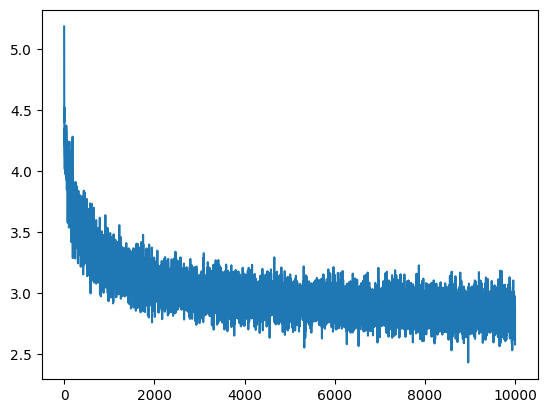

In [2]:
history = {"train": [], "val": []}
for s in range(10000):
    optim.zero_grad()

    x_enc, x_dec, y = generate_batch(batch_size, block_size, train)
    y_pred = model([x_enc, x_dec])
    l = loss.calculate(y, y_pred)
    history["train"].append(l)

    model.backward(loss.backward())
    optim.step()

    if s % 500 == 0:
        #optim = GD(model.parameters(), optim.lr / 10)
        x_enc, x_dec, y = generate_batch(batch_size*10, block_size, val)
        y_pred = model([x_enc, x_dec])
        l = loss.calculate(y, y_pred)
        history["val"] += 500 * [l]
        print(f"step: {s}, train loss: {np.mean(history['train'][-500:]):.3f}, val loss: {l:.3f}")

plt.plot(history["train"], label="train")
print(f"min loss: {min(history['train'])}")

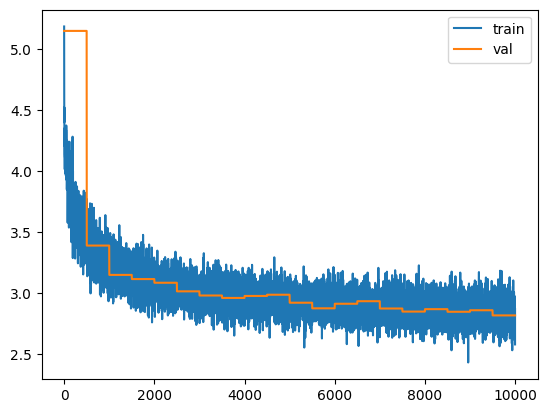

In [3]:
plt.plot(history["train"], label="train")
plt.plot(history["val"], label="val")
plt.legend()